# Face Parts Segmentation
For dataset and model definitions, see `dataset.py` and `model.py`.

I used the following references for the implementation:
* https://www.kaggle.com/dhananjay3/image-segmentation-from-scratch-in-pytorch
* https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/

## Imports

In [83]:
%reload_ext autoreload
import os
import numpy as np
from model import UNetLight
from dataset import Dataset, rgb2name
from tqdm import tqdm
from torch.optim import Adam
import torch.nn as nn
import torch
from datetime import datetime
from utils import accuracy, to_numpy
import albumentations as albu
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Augmentations
We use the `albumentations` package for augmentations.
Note that `img_width` is quite low to accelerate the training and reduce overfit.

In [8]:
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)
aspect_ratio = 1.44
img_width = 100
img_size = [int(img_width*r) for r in [aspect_ratio, 1]]
train_transform = albu.Compose([albu.HorizontalFlip(p=0.5),
                                albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                                albu.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                                albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                                albu.Resize(*img_size),
                                albu.Normalize(mean=mean_rgb, std=std_rgb)])
val_transform = albu.Compose([albu.Resize(*img_size),
                              albu.Normalize(mean=mean_rgb, std=std_rgb)])

## Data Loaders
The `Dataset` class is a custom subclass of `torch.utils.data.Dataset`,
and therefore can be directly used with `torch.utils.data.DataLoader`.
Increase `num_workers` to accelerate training (but set to 0 while debugging).

Modify the folder paths arguments in the `Dataset` calls as needed.
Also note that in my experiments, I used 50 samples for training, and 20 for validation.

In [9]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 0}
train_set = Dataset('data/Train_RGB', 'data/Train_Labels', train_transform)
train_loader = torch.utils.data.DataLoader(train_set, **params)
val_set = Dataset('data/Test_RGB', 'data/Test_Labels', val_transform)
val_loader = torch.utils.data.DataLoader(val_set, **params)

## Model, Optimizer and Loss.
We use a cross entropy loss, with weighting to compensate the class imbalance.
A class weight is inversely proportional to its frequency in the training set.

We also used a learning rate scheduler.

The model architecture is identical to [UNet](https://arxiv.org/abs/1505.04597), however the number of kernels in each layer is reduced by a factor of 2.

In [90]:
model = UNetLight(n_channels=train_loader.dataset.num_channels, n_classes=train_loader.dataset.num_classes, k=32)
optimizer = Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
loss_fcn = nn.CrossEntropyLoss(weight=train_loader.dataset.class_weights())

## Train loop
The training loop is standard.
At each epoch, we do a forward pass, a backward pass, and parameters update, for each training batch.
Then, we evaluate the performance on the validation set (in batches).
If the validation loss is reduced, the model is saved to the folder `saved_models`,
with a name according to the timestamp at the beginning of training.
We also record the loss and accuracy (fraction of pixels classified correctly) on both training and validation sets.

I reached about 90% validation accuracy, and 0.43 validation loss after 50 epochs (about 12 minutes on my computer).

In [91]:
save_path = os.path.join('saved_models', str(datetime.now()) + '.pt')
n_epochs = 50
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
lr_rate_list = []
valid_loss_min = np.Inf  # track change in validation loss

epoch_bar = tqdm(range(1, n_epochs + 1), desc=' Epochs')
for epoch in epoch_bar:
    # train
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        batch_loss = loss_fcn(output, target)
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item() * data.shape[0]
        batch_acc = accuracy(output, target)
        train_acc += batch_acc * data.shape[0]

    # validate
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            batch_loss = loss_fcn(output, target)
            val_loss += batch_loss.item() * data.shape[0]
            batch_acc = accuracy(output, target)
            val_acc += batch_acc * data.shape[0]

    # calculate average losses and append to lists
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    epoch_bar.write('')
    epoch_bar.write('epoch: {}  train_loss: {:.3f}  val_loss: {:.3f} train acc: {:.3f}  val_acc: {:.3f}'
                    .format(epoch, train_loss, val_loss, train_acc, val_acc))

    # save model (if improved on val set)
    if val_loss <= valid_loss_min:
        epoch_bar.write('Validation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'
                        .format(valid_loss_min, val_loss))
        torch.save(model.state_dict(), save_path)
        valid_loss_min = val_loss

    scheduler.step(val_loss)

 Epochs:   2%|▏         | 1/50 [00:15<12:34, 15.40s/it]


epoch: 1  train_loss: 1.813  val_loss: 1.791 train acc: 0.135  val_acc: 0.145
Validation loss decreased (inf --> 1.791).  Saving model ...


 Epochs:   4%|▍         | 2/50 [00:30<12:09, 15.19s/it]


epoch: 2  train_loss: 1.615  val_loss: 1.787 train acc: 0.245  val_acc: 0.142
Validation loss decreased (1.791 --> 1.787).  Saving model ...


 Epochs:   6%|▌         | 3/50 [00:44<11:40, 14.90s/it]


epoch: 3  train_loss: 1.505  val_loss: 1.773 train acc: 0.340  val_acc: 0.160
Validation loss decreased (1.787 --> 1.773).  Saving model ...


 Epochs:   8%|▊         | 4/50 [00:58<11:18, 14.76s/it]


epoch: 4  train_loss: 1.469  val_loss: 1.754 train acc: 0.393  val_acc: 0.266
Validation loss decreased (1.773 --> 1.754).  Saving model ...


 Epochs:  10%|█         | 5/50 [01:13<11:00, 14.68s/it]


epoch: 5  train_loss: 1.407  val_loss: 1.728 train acc: 0.423  val_acc: 0.259
Validation loss decreased (1.754 --> 1.728).  Saving model ...


 Epochs:  12%|█▏        | 6/50 [01:27<10:42, 14.60s/it]


epoch: 6  train_loss: 1.351  val_loss: 1.699 train acc: 0.417  val_acc: 0.237
Validation loss decreased (1.728 --> 1.699).  Saving model ...


 Epochs:  14%|█▍        | 7/50 [01:42<10:26, 14.58s/it]


epoch: 7  train_loss: 1.264  val_loss: 1.667 train acc: 0.422  val_acc: 0.236
Validation loss decreased (1.699 --> 1.667).  Saving model ...


 Epochs:  16%|█▌        | 8/50 [01:56<10:07, 14.47s/it]


epoch: 8  train_loss: 1.146  val_loss: 1.640 train acc: 0.457  val_acc: 0.285
Validation loss decreased (1.667 --> 1.640).  Saving model ...


 Epochs:  18%|█▊        | 9/50 [02:10<09:52, 14.44s/it]


epoch: 9  train_loss: 1.094  val_loss: 1.614 train acc: 0.466  val_acc: 0.294
Validation loss decreased (1.640 --> 1.614).  Saving model ...


 Epochs:  20%|██        | 10/50 [02:25<09:36, 14.40s/it]


epoch: 10  train_loss: 1.064  val_loss: 1.580 train acc: 0.469  val_acc: 0.310
Validation loss decreased (1.614 --> 1.580).  Saving model ...


 Epochs:  22%|██▏       | 11/50 [02:39<09:21, 14.39s/it]


epoch: 11  train_loss: 1.018  val_loss: 1.530 train acc: 0.505  val_acc: 0.323
Validation loss decreased (1.580 --> 1.530).  Saving model ...


 Epochs:  24%|██▍       | 12/50 [02:54<09:09, 14.47s/it]


epoch: 12  train_loss: 0.993  val_loss: 1.436 train acc: 0.497  val_acc: 0.359
Validation loss decreased (1.530 --> 1.436).  Saving model ...


 Epochs:  26%|██▌       | 13/50 [03:08<08:55, 14.49s/it]


epoch: 13  train_loss: 0.941  val_loss: 1.350 train acc: 0.518  val_acc: 0.433
Validation loss decreased (1.436 --> 1.350).  Saving model ...


 Epochs:  28%|██▊       | 14/50 [03:23<08:43, 14.53s/it]


epoch: 14  train_loss: 0.891  val_loss: 1.192 train acc: 0.538  val_acc: 0.485
Validation loss decreased (1.350 --> 1.192).  Saving model ...


 Epochs:  30%|███       | 15/50 [03:37<08:26, 14.46s/it]


epoch: 15  train_loss: 0.833  val_loss: 1.062 train acc: 0.584  val_acc: 0.526
Validation loss decreased (1.192 --> 1.062).  Saving model ...


 Epochs:  32%|███▏      | 16/50 [03:51<08:09, 14.41s/it]


epoch: 16  train_loss: 0.821  val_loss: 0.926 train acc: 0.607  val_acc: 0.548
Validation loss decreased (1.062 --> 0.926).  Saving model ...


 Epochs:  34%|███▍      | 17/50 [04:06<07:54, 14.37s/it]


epoch: 17  train_loss: 0.787  val_loss: 0.861 train acc: 0.665  val_acc: 0.563
Validation loss decreased (0.926 --> 0.861).  Saving model ...


 Epochs:  36%|███▌      | 18/50 [04:20<07:38, 14.31s/it]


epoch: 18  train_loss: 0.743  val_loss: 0.820 train acc: 0.700  val_acc: 0.586
Validation loss decreased (0.861 --> 0.820).  Saving model ...


 Epochs:  38%|███▊      | 19/50 [04:34<07:23, 14.30s/it]


epoch: 19  train_loss: 0.744  val_loss: 0.790 train acc: 0.681  val_acc: 0.633
Validation loss decreased (0.820 --> 0.790).  Saving model ...


 Epochs:  40%|████      | 20/50 [04:48<07:08, 14.28s/it]


epoch: 20  train_loss: 0.719  val_loss: 0.758 train acc: 0.706  val_acc: 0.687
Validation loss decreased (0.790 --> 0.758).  Saving model ...


 Epochs:  42%|████▏     | 21/50 [05:03<06:54, 14.28s/it]


epoch: 21  train_loss: 0.718  val_loss: 0.714 train acc: 0.698  val_acc: 0.690
Validation loss decreased (0.758 --> 0.714).  Saving model ...


 Epochs:  44%|████▍     | 22/50 [05:17<06:39, 14.28s/it]


epoch: 22  train_loss: 0.688  val_loss: 0.686 train acc: 0.694  val_acc: 0.700
Validation loss decreased (0.714 --> 0.686).  Saving model ...


 Epochs:  46%|████▌     | 23/50 [05:31<06:24, 14.25s/it]


epoch: 23  train_loss: 0.640  val_loss: 0.653 train acc: 0.729  val_acc: 0.719
Validation loss decreased (0.686 --> 0.653).  Saving model ...


 Epochs:  48%|████▊     | 24/50 [05:45<06:11, 14.28s/it]


epoch: 24  train_loss: 0.629  val_loss: 0.641 train acc: 0.733  val_acc: 0.737
Validation loss decreased (0.653 --> 0.641).  Saving model ...


 Epochs:  50%|█████     | 25/50 [06:00<05:56, 14.27s/it]


epoch: 25  train_loss: 0.575  val_loss: 0.606 train acc: 0.763  val_acc: 0.747
Validation loss decreased (0.641 --> 0.606).  Saving model ...


 Epochs:  52%|█████▏    | 26/50 [06:14<05:42, 14.29s/it]


epoch: 26  train_loss: 0.576  val_loss: 0.579 train acc: 0.732  val_acc: 0.774
Validation loss decreased (0.606 --> 0.579).  Saving model ...


 Epochs:  54%|█████▍    | 27/50 [06:29<05:30, 14.36s/it]


epoch: 27  train_loss: 0.545  val_loss: 0.536 train acc: 0.774  val_acc: 0.793
Validation loss decreased (0.579 --> 0.536).  Saving model ...


 Epochs:  56%|█████▌    | 28/50 [06:43<05:15, 14.36s/it]


epoch: 28  train_loss: 0.567  val_loss: 0.513 train acc: 0.755  val_acc: 0.821
Validation loss decreased (0.536 --> 0.513).  Saving model ...


 Epochs:  58%|█████▊    | 29/50 [06:57<05:00, 14.32s/it]


epoch: 29  train_loss: 0.518  val_loss: 0.493 train acc: 0.809  val_acc: 0.835
Validation loss decreased (0.513 --> 0.493).  Saving model ...


 Epochs:  60%|██████    | 30/50 [07:11<04:45, 14.30s/it]


epoch: 30  train_loss: 0.510  val_loss: 0.481 train acc: 0.816  val_acc: 0.841
Validation loss decreased (0.493 --> 0.481).  Saving model ...


 Epochs:  62%|██████▏   | 31/50 [07:25<04:30, 14.25s/it]


epoch: 31  train_loss: 0.504  val_loss: 0.483 train acc: 0.823  val_acc: 0.852


 Epochs:  64%|██████▍   | 32/50 [07:40<04:16, 14.25s/it]


epoch: 32  train_loss: 0.490  val_loss: 0.476 train acc: 0.828  val_acc: 0.862
Validation loss decreased (0.481 --> 0.476).  Saving model ...


 Epochs:  66%|██████▌   | 33/50 [07:54<04:02, 14.24s/it]


epoch: 33  train_loss: 0.466  val_loss: 0.460 train acc: 0.861  val_acc: 0.867
Validation loss decreased (0.476 --> 0.460).  Saving model ...


 Epochs:  68%|██████▊   | 34/50 [08:08<03:48, 14.28s/it]


epoch: 34  train_loss: 0.459  val_loss: 0.449 train acc: 0.863  val_acc: 0.872
Validation loss decreased (0.460 --> 0.449).  Saving model ...


 Epochs:  70%|███████   | 35/50 [08:23<03:34, 14.27s/it]


epoch: 35  train_loss: 0.453  val_loss: 0.443 train acc: 0.860  val_acc: 0.874
Validation loss decreased (0.449 --> 0.443).  Saving model ...


 Epochs:  72%|███████▏  | 36/50 [08:37<03:19, 14.26s/it]


epoch: 36  train_loss: 0.461  val_loss: 0.446 train acc: 0.853  val_acc: 0.885


 Epochs:  74%|███████▍  | 37/50 [08:51<03:05, 14.26s/it]


epoch: 37  train_loss: 0.453  val_loss: 0.458 train acc: 0.863  val_acc: 0.891


 Epochs:  76%|███████▌  | 38/50 [09:05<02:51, 14.28s/it]


epoch: 38  train_loss: 0.454  val_loss: 0.468 train acc: 0.859  val_acc: 0.895


 Epochs:  78%|███████▊  | 39/50 [09:20<02:37, 14.30s/it]


epoch: 39  train_loss: 0.445  val_loss: 0.453 train acc: 0.871  val_acc: 0.895


 Epochs:  80%|████████  | 40/50 [09:34<02:23, 14.34s/it]


epoch: 40  train_loss: 0.443  val_loss: 0.439 train acc: 0.871  val_acc: 0.895
Validation loss decreased (0.443 --> 0.439).  Saving model ...


 Epochs:  82%|████████▏ | 41/50 [09:49<02:09, 14.39s/it]


epoch: 41  train_loss: 0.440  val_loss: 0.432 train acc: 0.872  val_acc: 0.894
Validation loss decreased (0.439 --> 0.432).  Saving model ...


 Epochs:  84%|████████▍ | 42/50 [10:03<01:55, 14.40s/it]


epoch: 42  train_loss: 0.437  val_loss: 0.427 train acc: 0.873  val_acc: 0.895
Validation loss decreased (0.432 --> 0.427).  Saving model ...


 Epochs:  86%|████████▌ | 43/50 [10:18<01:41, 14.45s/it]


epoch: 43  train_loss: 0.424  val_loss: 0.424 train acc: 0.886  val_acc: 0.894
Validation loss decreased (0.427 --> 0.424).  Saving model ...


 Epochs:  88%|████████▊ | 44/50 [10:32<01:26, 14.44s/it]


epoch: 44  train_loss: 0.428  val_loss: 0.422 train acc: 0.881  val_acc: 0.895
Validation loss decreased (0.424 --> 0.422).  Saving model ...


 Epochs:  90%|█████████ | 45/50 [10:46<01:12, 14.42s/it]


epoch: 45  train_loss: 0.426  val_loss: 0.422 train acc: 0.883  val_acc: 0.896
Validation loss decreased (0.422 --> 0.422).  Saving model ...


 Epochs:  92%|█████████▏| 46/50 [11:01<00:57, 14.41s/it]


epoch: 46  train_loss: 0.432  val_loss: 0.424 train acc: 0.873  val_acc: 0.899


 Epochs:  94%|█████████▍| 47/50 [11:15<00:43, 14.40s/it]


epoch: 47  train_loss: 0.434  val_loss: 0.427 train acc: 0.874  val_acc: 0.900


 Epochs:  96%|█████████▌| 48/50 [11:29<00:28, 14.35s/it]


epoch: 48  train_loss: 0.416  val_loss: 0.431 train acc: 0.889  val_acc: 0.900


 Epochs:  98%|█████████▊| 49/50 [11:44<00:14, 14.31s/it]


epoch: 49  train_loss: 0.412  val_loss: 0.431 train acc: 0.891  val_acc: 0.900


 Epochs: 100%|██████████| 50/50 [11:58<00:00, 14.37s/it]


epoch: 50  train_loss: 0.420  val_loss: 0.429 train acc: 0.883  val_acc: 0.899


# Plot Metrics

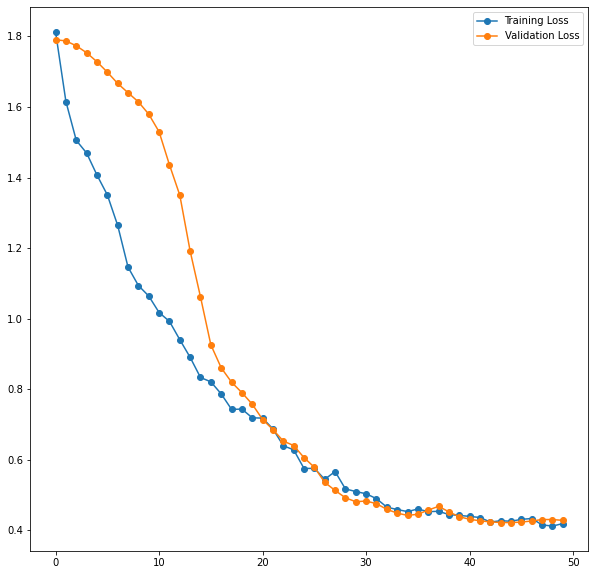

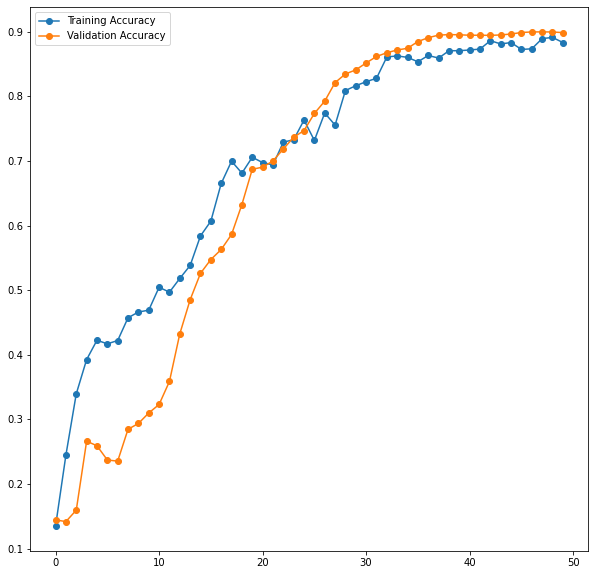

In [92]:
# loss
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(val_loss_list,  marker='o', label="Validation Loss")
plt.legend()
plt.show()
# accuracy
plt.figure(figsize=(10,10))
plt.plot(train_acc_list,  marker='o', label="Training Accuracy")
plt.plot(val_acc_list,  marker='o', label="Validation Accuracy")
plt.legend()
plt.show()

## Results
Plot some examples from the validation set:

In [107]:
def plot(x_batch, out_batch, gt_batch):
    batch_size = x_batch.shape[0]
    num_classes = out_batch.shape[1]

    # cancel rgb normalization
    x_batch = x_batch.transpose([0, 2, 3, 1])
    mean_np = np.array([[[[*mean_rgb]]]])
    std_np = np.array([[[[*std_rgb]]]])
    x_batch *= std_np
    x_batch += mean_np

    fig, ax = plt.subplots(batch_size, 4, figsize=(16, 4*batch_size))
    for i, x, y, gt in zip(range(batch_size), x_batch, out_batch, gt_batch):
        ax[i, 0].imshow(x)
        ax[i, 1].imshow(gt)
        ax[i, 2].imshow(y)
        ax[i, 3].imshow((y == gt).astype(np.float))
    ax[0, 0].set_title("input")
    ax[0, 1].set_title("target")
    ax[0, 2].set_title("output")
    ax[0, 3].set_title("output == target")
    fig.show()

/Users/tomshlomo/opt/anaconda3/envs/CommonGround-hw/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



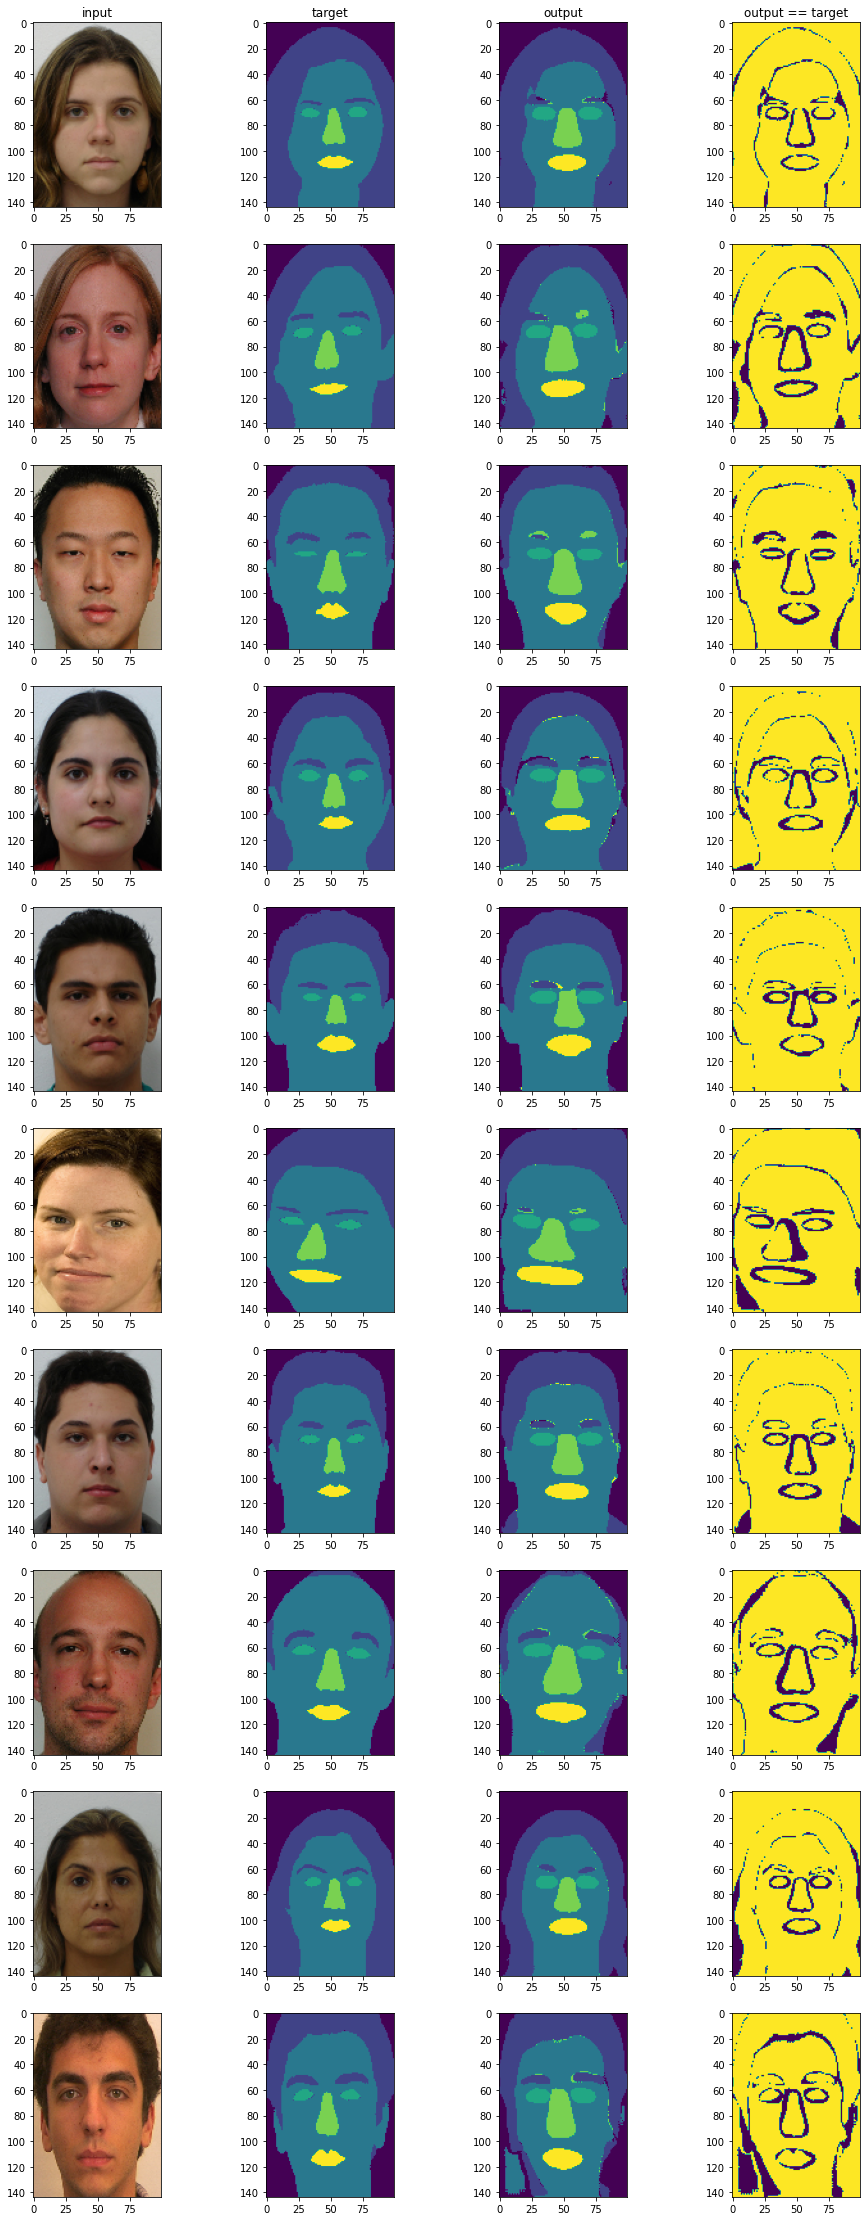

In [108]:
data, target = next(iter(val_loader))
output = model(data).argmax(axis=1)
data = to_numpy(data)
output = to_numpy(output)
target = to_numpy(target)
n = 10
plot(data[:n], output[:n], target[:n])

We can see that it is common for the model to enlarge the eyes, mouth and nose.  
Also, skin, background and hair tend to mix.  
Calculate and plot the confusion matrix to verify:

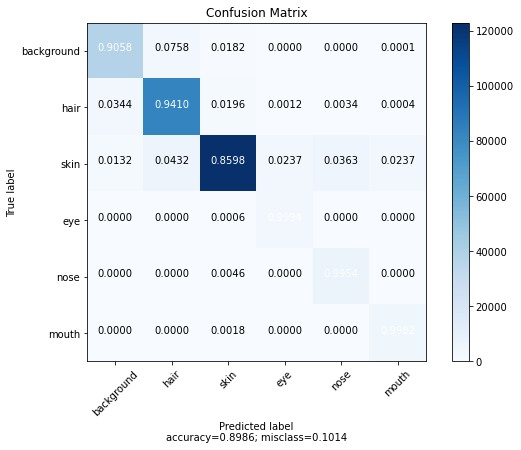

In [109]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    acc = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - acc

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(acc, misclass))
    plt.show()
cm = confusion_matrix(target.flatten(), output.flatten())
plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = rgb2name.values(),
                      title        = "Confusion Matrix")


Plot worst and best examples (by accuracy):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13, 10]


/Users/tomshlomo/opt/anaconda3/envs/CommonGround-hw/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



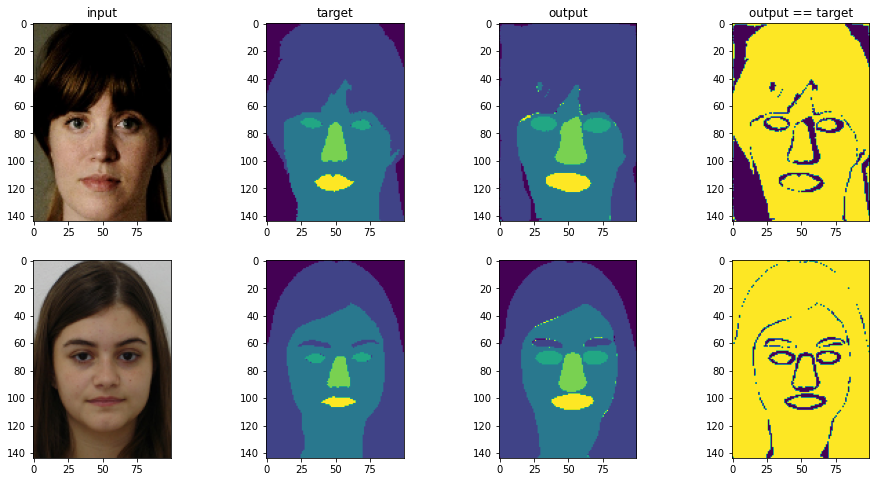

In [110]:
acc = np.sum((target == output).astype(np.float), axis=(1,2))
ind = [acc.argmin(), acc.argmax()]
print(ind)
plot(data[ind], output[ind], target[ind])

## Conclusions
Given more time, training data, computation power and training time, we could:
* Increase model capacity (for example by doubling the number of kernels, going back to the original UNet).
* Test [different newtork architectures](https://arxiv.org/abs/1912.10230).
* Add weights regularization to improve generilzation.
* Test out different loss functions. Specifically, [soft versions of the dice loss](https://arxiv.org/abs/2006.14822), and [loss functions that give extra penalty for errors near segments boundaries](https://arxiv.org/abs/1505.04597). 